<a target="_blank" rel="noopener noreferrer" href="https://colab.research.google.com/github/ccaudek/ds4psy_2023/blob/main/05_counterfactual.ipynb">![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)</a>

(causal-analysis-notebook)=
# Analisi causale con PyMC

Il codice di questo Notebook è ricavato dal sito ufficiale di PyMC.

In [33]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pymc as pm
import pymc.sampling_jax
import bambi as bmb
import seaborn as sns
import arviz as az
import networkx as nx
import warnings

warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=Warning)

In [34]:
%config InlineBackend.figure_format = 'retina'
RANDOM_SEED = 12345
rng = np.random.default_rng(RANDOM_SEED)
az.style.use("arviz-viridish")

## Valutazione dell'efficacia della Terapia Cognitivo-Comportamentale (TCC) 

Supponiamo di essere interessati a valutare l'efficacia della Terapia Cognitivo-Comportamentale (TCC) nei pazienti. La TCC è una forma di psicoterapia che mira a cambiare schemi negativi di pensiero o comportamento. L'obiettivo principale è quantificare quanto sia efficace la TCC nel miglioramento della qualità della vita, in particolare nella riduzione dei livelli di ansia.

Viene eseguito uno studio in cui la qualità della vita viene misurata prima e dopo un determinato periodo di trattamento con la TCC. 

Alcuni dei pazienti che partecipano allo studio sono anche iscritti a un programma separato di meditazione mindfulness finalizzato alla riduzione dell'ansia. Questi pazienti praticano tecniche di mindfulness in aggiunta alla TCC. Inoltre, questi pazienti tendono a praticare la mindfulness con maggiore diligenza nei giorni in cui hanno sessioni di TCC, credendo che le due terapie si complementino a vicenda nella riduzione dell'ansia.

Questa situazione crea una variabile confondente. Il miglioramento della qualità della vita potrebbe essere dovuto all'effetto combinato della TCC e della meditazione mindfulness, e non della TCC da sola. Un semplice confronto prima e dopo dei livelli di ansia nel gruppo TCC potrebbe quindi portare a una sovrastima dell'efficacia della TCC nel miglioramento della qualità della vita.

Per valutare accuratamente l'impatto della sola TCC, è dunque necessario controllare l'influenza del programma di meditazione mindfulness. Vedremo qui come questo possa essere fatto utilizzando PyMC e un ragionamento controfattuale.

## Formalizzazione della rete causale bayesiana sottostante

Possiamo rappresentare la situazione dell'esempio sopra descritto con un grafo aciclico diretto (DAG) causale in cui abbiamo una variabile di trattamento binaria (trattamento con CTT, presente/assente) che può o non può influenzare causalmente un risultato (sintomi d'ansia). Tuttavia, questa relazione è soggetta a confondimento a causa della pratica della mindfulness, che influenza causalmente sia il trattamento che l'esito. Trasformiamo questo esempio in un DAG causale bayesiano, specificando relazioni causali probabilistiche tra i nodi. Un prior è associato a C, in quanto non ha nodi genitori.

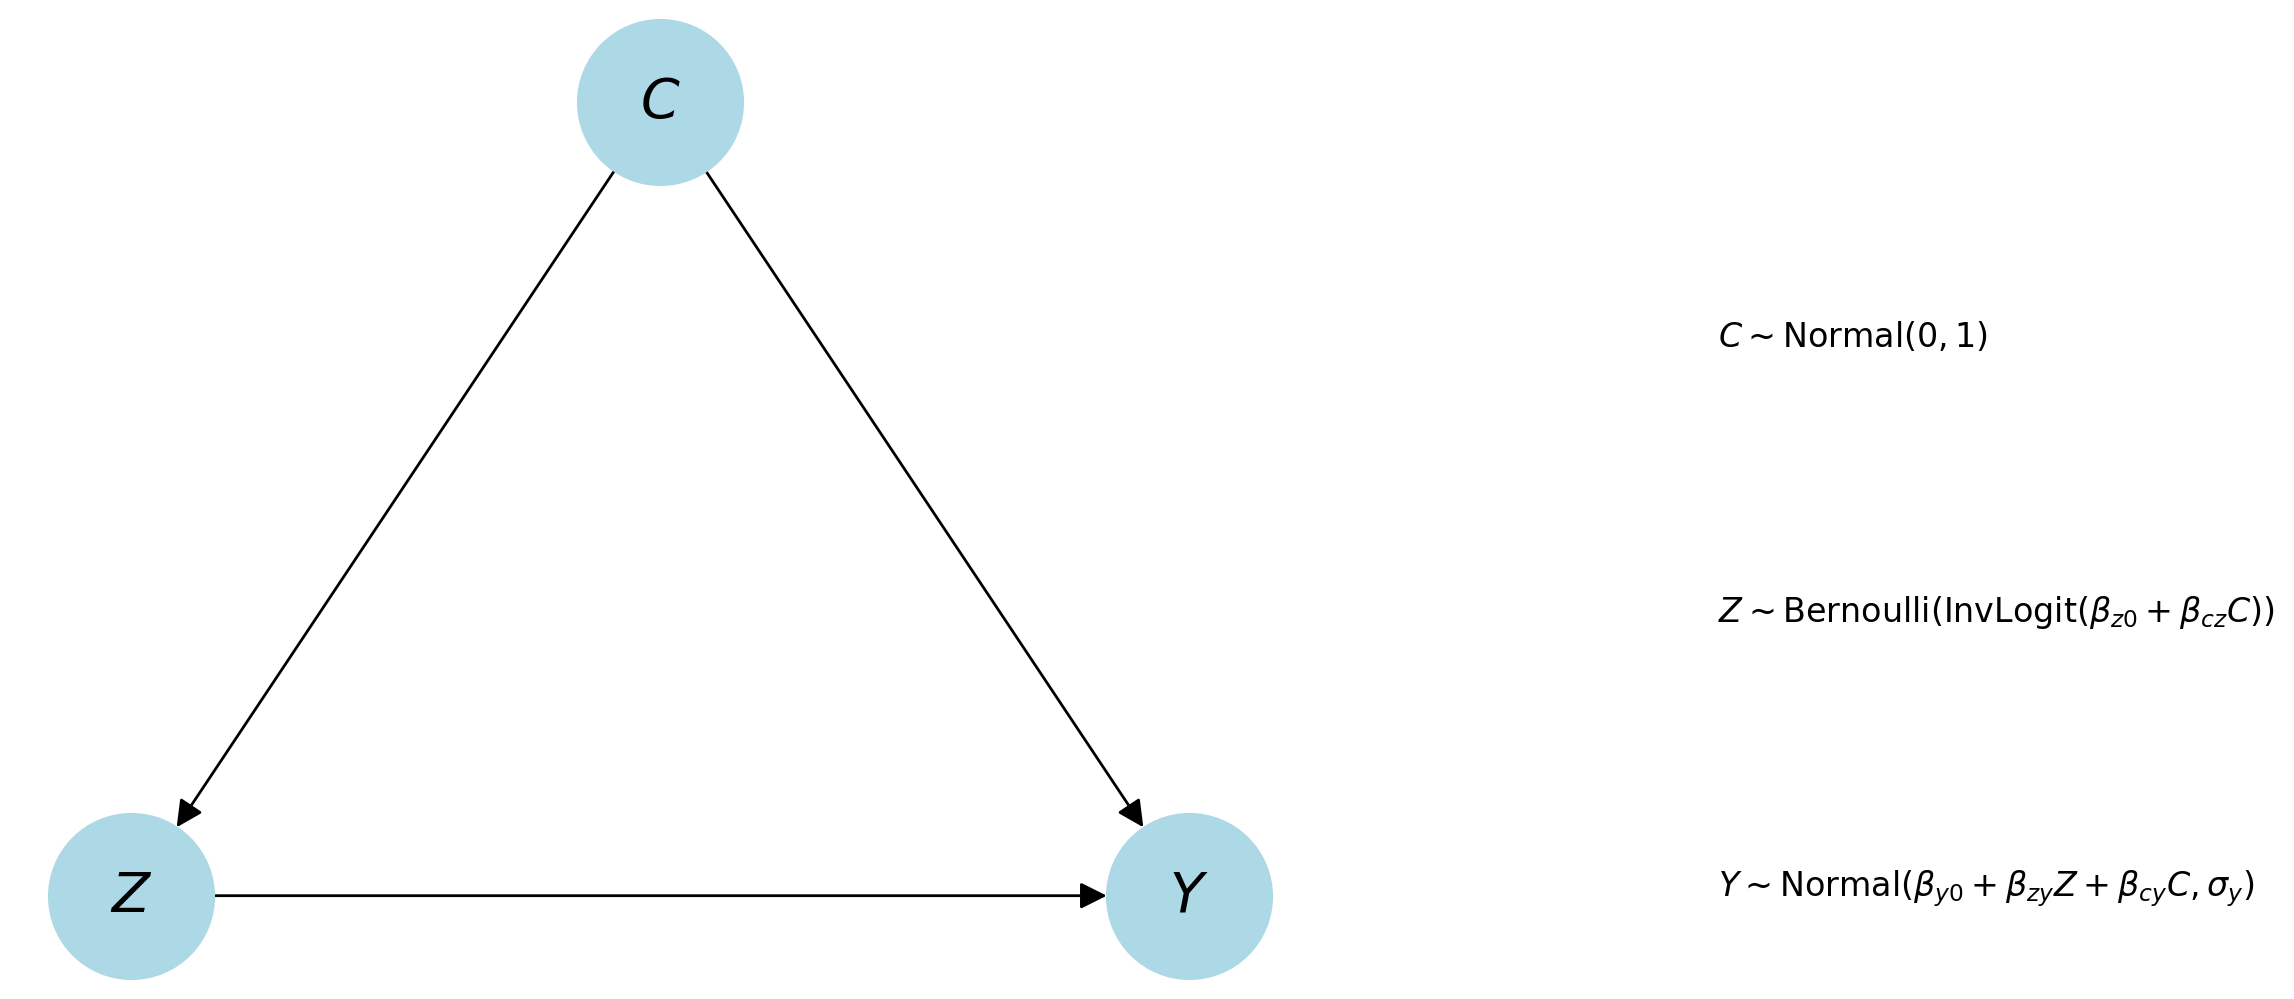

In [35]:
# Initialize a directed graph
g = nx.DiGraph()

# Add nodes
g.add_nodes_from(["Y", "Z", "C"])

# Add edges
g.add_edges_from([("Z", "Y"), ("C", "Y"), ("C", "Z")])

# Draw the graph
pos = {"Y": (0, 0), "Z": (-1, 0), "C": (-0.5, 0.866)}
labels = {"Y": r"$Y$", "Z": r"$Z$", "C": r"$C$"}

# Add edges and nodes to the plot
nx.draw(
    g,
    pos,
    labels=labels,
    with_labels=True,
    node_size=3500,
    node_color="lightblue",
    font_size=20,
    font_color="black",
    font_weight="bold",
    arrowsize=20,
)

# Add text/annotations
plt.text(0.5, 0.6, r"$C \sim \mathrm{Normal}(0, 1)$", fontsize=12)
plt.text(
    0.5,
    0.3,
    r"$Z \sim \mathrm{Bernoulli}(\operatorname{InvLogit}(\beta_{z0} + \beta_{cz} C))$",
    fontsize=12,
)
plt.text(
    0.5,
    0,
    r"$Y \sim \mathrm{Normal}(\beta_{y0} + \beta_{zy} Z + \beta_{cy} C, \sigma_y)$",
    fontsize=12,
)

plt.show()

Come si può vedere, stiamo essenzialmente impostando due regressioni: una regressione logistica di $ C $ su $ Z $, e una regressione lineare di $ C $ *e* $ Z $ su $ Y $. Il nostro principale interesse in questa analisi riguarda la relazione tra il trattamento $ Z $ e l'esito $ Y $. Possiamo dunque notare come questo esempio rappresenti una tipica _relazione confondente_."

Il nostro obiettivo in questo esempio è determinare la forza della relazione causale $ Z \rightarrow Y $, espressa attraverso il parametro $ \beta_{ZY} $. Supponendo che questa rappresenti una descrizione causale accurata e completa dei nostri dati, possiamo quantificare la variazione dei sintomi d'ansia che è causata dalla terapia TCC.

Si noti che in questo capitolo presupponiamo di conoscere già il grafo causale. Quando ciò non è vero, dobbiamo ricorrere a metodi di [scoperta causale](https://en.wikipedia.org/wiki/Exploratory_causal_analysis).

Prima di addentrarci nel codice, definiamo alcune notazioni per semplificare il discorso:
* Disponiamo delle variabili casuali $ C $, $ Z $, e $ Y $.
* Queste differiscono dalle osservazioni, ovvero dai valori specifici, $ c $, $ z $, e $ y $.
* Abbiamo un insieme di parametri latenti, $ \theta = \{ \beta_{z0}, \beta_{y0}, \beta_{zy}, \beta_{zy}, \beta_{cz}, \sigma_{y} \} $.

### Definizione del modello generativo dei dati

Il passo successivo consiste nella definizione di un modello 'vuoto', non condizionato su alcun dato. Questo può essere visto come una descrizione 'pura' del nostro processo di generazione dei dati, completamente scollegata da qualsiasi dato effettivo. Seguiremo qui la stessa procedura usata nel capitolo {ref}`reglin-param-recovery-notebook`, usando però una rete bayesiana diversa.

In [36]:
with pm.Model(coords_mutable={"i": [0]}) as model_generative:
    # priors on Y <- C -> Z
    beta_y0 = pm.Normal("beta_y0")
    beta_cy = pm.Normal("beta_cy")
    beta_cz = pm.Normal("beta_cz")
    # priors on Z -> Y causal path
    beta_z0 = pm.Normal("beta_z0")
    beta_zy = pm.Normal("beta_zy")
    # observation noise on Y
    sigma_y = pm.HalfNormal("sigma_y")
    # core nodes and causal relationships
    c = pm.Normal("c", mu=0, sigma=1, dims="i")
    z = pm.Bernoulli("z", p=pm.invlogit(beta_z0 + beta_cz * c), dims="i")
    y_mu = pm.Deterministic("y_mu", beta_y0 + (beta_zy * z) + (beta_cy * c), dims="i")
    y = pm.Normal("y", mu=y_mu, sigma=sigma_y, dims="i")

Generiamo il DAG corrispondente al modello definito sopra.

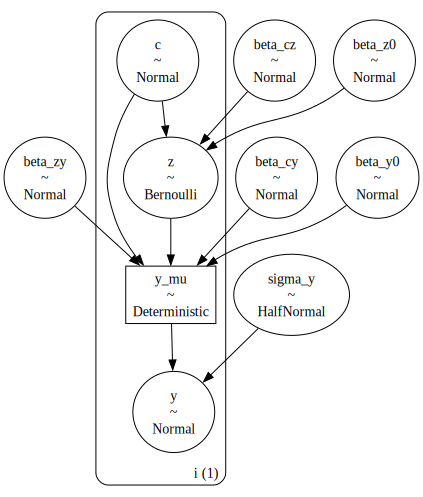

In [37]:
pm.model_to_graphviz(model_generative)

## Simulazione dei dati

Dopo aver definito l'intera distribuzione congiunta, la useremo inizialmente per generare dati simulati con dimensioni degli effetti note, per poi testare se siamo in grado di recuperarli.

Per fare ciò, specificheremo alcuni valori reali dei parametri che regolano le relazioni causali tra i nodi. Importante è che impostiamo la vera influenza causale di $ Z $ su $ Y $ uguale a 0, ossia $ \beta_{ZY} = 0 $. Questo è conosciuto come il vero Effetto Medio del Trattamento ([Average treatment effect](https://en.wikipedia.org/wiki/Average_treatment_effect), ATE). Nei termini dell'esempio pratico, ciò corrisponderebbe al fatto che il trattamento TCC non ha alcun effetto causale sulla riduzione dei sintomi d'ansia.

Ovviamente, nelle situazioni reali non sapppiamo quale sia il vero ATE. Qui lo sappiamo solo perché stiamo simulando i dati. Il nostro obiettivo è quello di stimare quale sia l'ATE, e verificare quanto bene possiamo dedurre i parametri noti solo dai dati.

Definiamo un dizionario che contiene i valori "veri" dei parametri.

In [38]:
true_ATE = 0.0

true_values = {
    "beta_z0": 0.0,
    "beta_y0": 0.0,
    "beta_cz": 1.5,
    "beta_zy": true_ATE,
    "beta_cy": 1.0,
    "sigma_y": 0.2,
}

Come in precedenza, usiamo la funzione `do` per creare una versione "fissata" di un modello generativo. Passiamo a `do` due argomenti: il modello generativo, definito come un oggetto `pymc.Model` e un dizionario (`true_values`) che specifica i valori a cui fissare le variabili casuali del modello. La funzione `do` restituisce un nuovo modello (`model_simulate`), in cui le variabili casuali originali sono sostituite da nodi costanti con i valori forniti nel dizionario.

In [39]:
model_simulate = pm.do(model_generative, true_values)

Possiamo ora usare `model_simulate` per simulare i dati. Usiamo `pm.sample_prior_predictive` perché campioniamo soltanto dalle distribuzioni a priori.

In [40]:
N = 100

with model_simulate:
    simulate = pm.sample_prior_predictive(samples=N, random_seed=rng)

observed = {
    "c": simulate.prior["c"].values.flatten(),
    "y": simulate.prior["y"].values.flatten(),
    "z": simulate.prior["z"].values.flatten(),
}

Sampling: [c, y, z]


Generiamo ora il DataFrame `df` che contiene i dati che abbiamo simulato.

In [42]:
df = pd.DataFrame(observed).sort_values("c", ascending=False)
df.head()

,c,y,z
14,2.525540,2.289737,1
43,2.150877,2.231028,1
67,1.591218,1.579474,1
49,1.556414,1.937416,1
68,1.468020,1.436564,1


In [43]:
df.shape

(100, 3)

Esaminiamo la distribuzione dei sintomi d'ansia nei gruppi con il trattamento TCC presente e assente. È chiaro dal grafico che le due distribuzioni sono chiaramente separate.

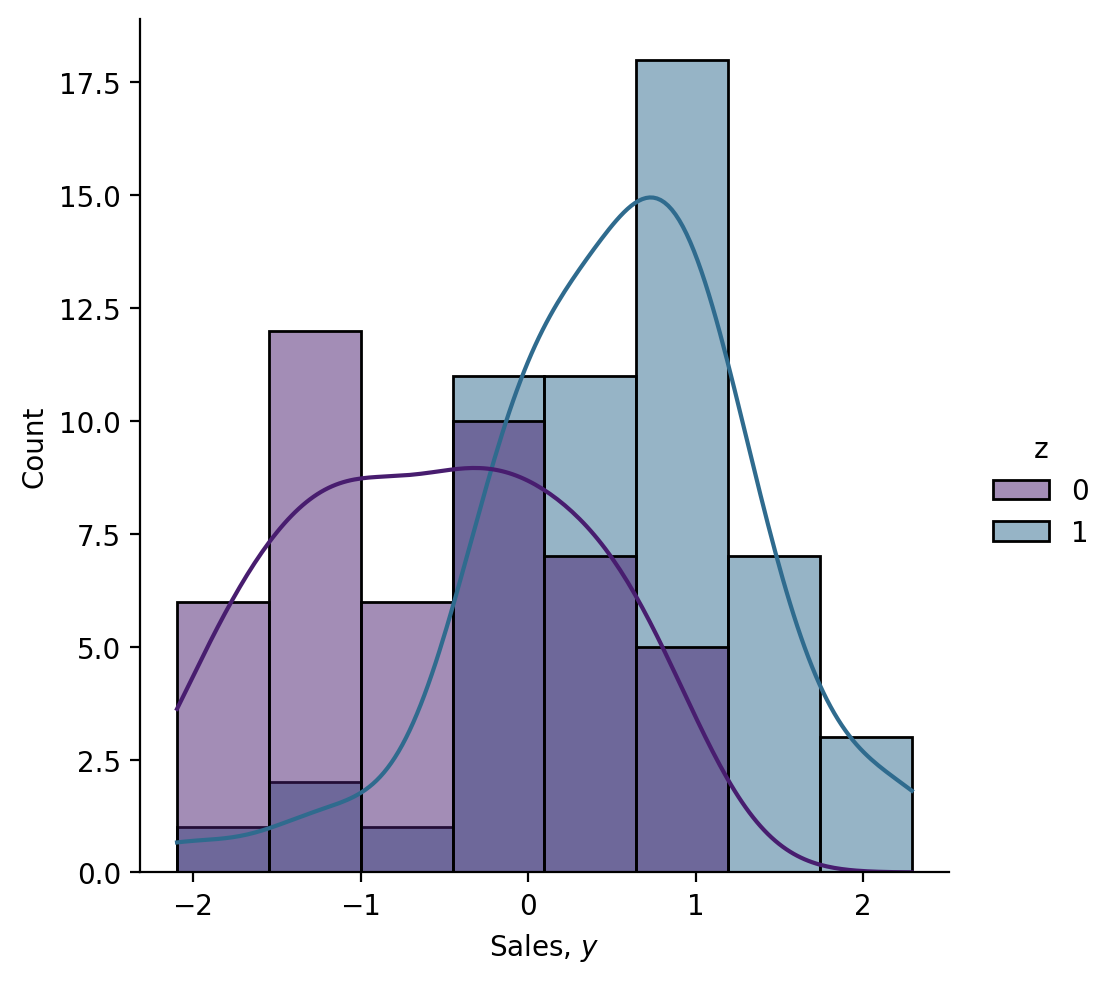

In [44]:
ax = sns.displot(data=df, x="y", hue="z", kde=True)
ax.set(xlabel="Sales, $y$");

In [47]:
model_bambi = bmb.Model("y ~ z", df)
idata_bambi = model_bambi.fit(method="nuts_numpyro")

Compiling...
Compilation time =  0:00:00.696124
Sampling...


Compiling.. :   0%|          | 0/2000 [00:00<?, ?it/s]





Running chain 0:   0%|          | 0/2000 [00:01<?, ?it/s]


Running chain 3: 100%|██████████| 2000/2000 [00:01<00:00, 1296.08it/s]

Sampling time =  0:00:01.628871
Transforming variables...
Transformation time =  0:00:00.004820


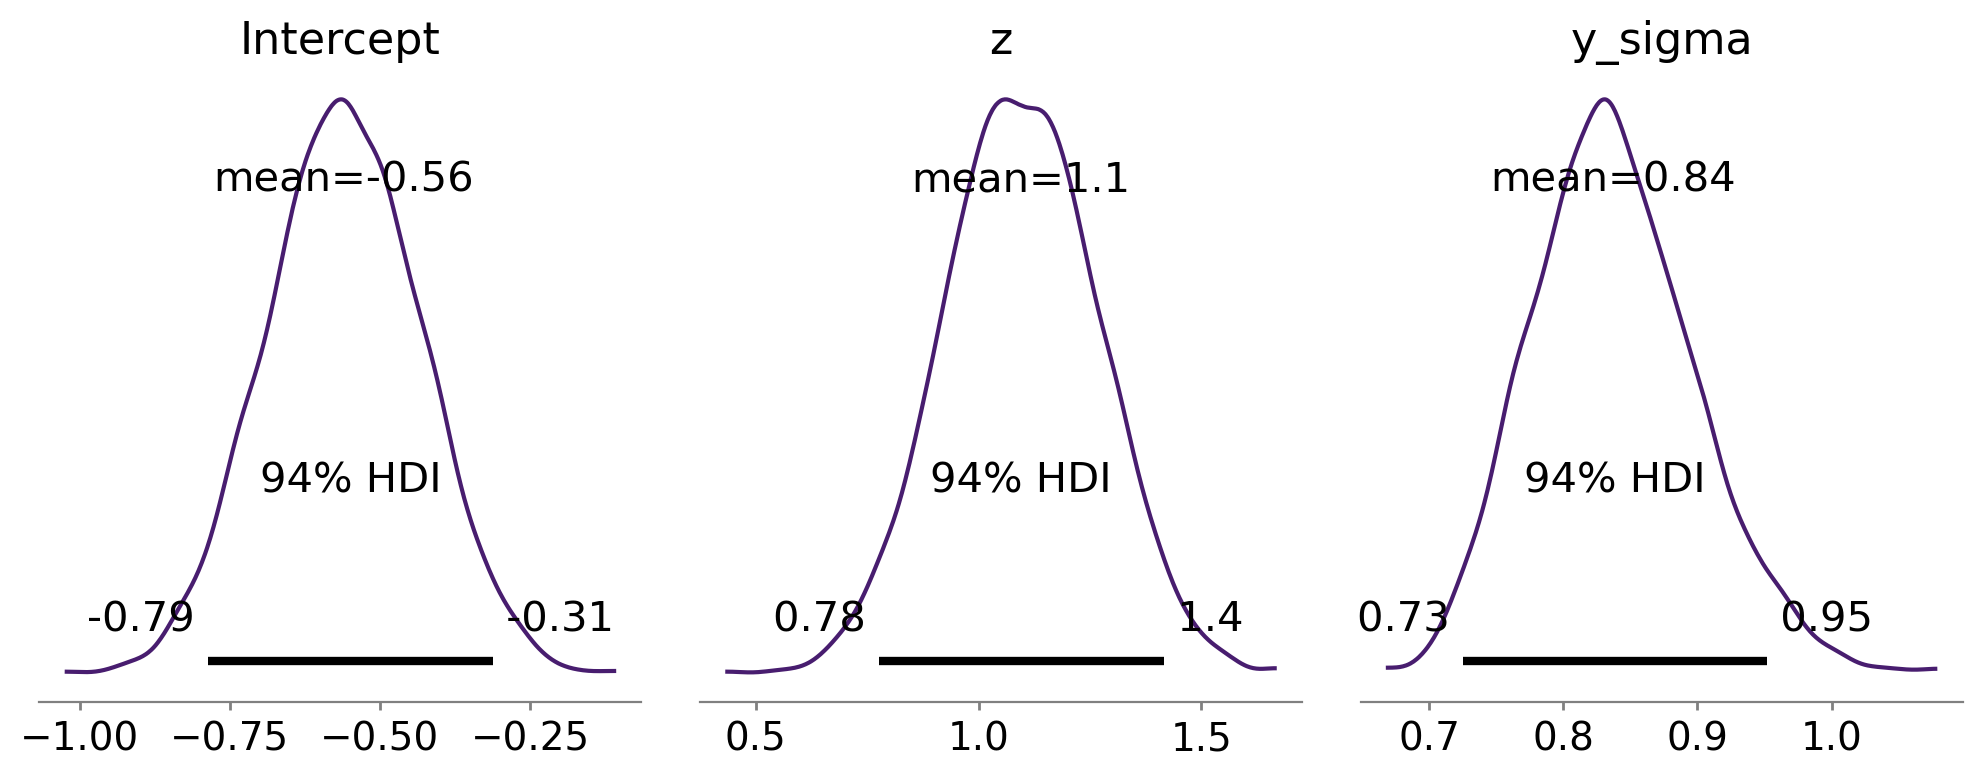

In [48]:
az.plot_posterior(
    idata_bambi,
    figsize=(10, 4),
)
plt.tight_layout();

Si noti che l'indicatore che quantifica l'ATE, ovvero l'effetto del trattamento con TCC sul miglioramento della qualità della vita, è pari a 0.87, con un intervallo di credibilità al 94% compreso tra 0.54 e 1.2. Sulla base di queste informazioni, saremmo portati a concludere che la TCC è efficace nel migliorare la qualità della vita riducendo i sintomi d'ansia. Tuttavia, questa conclusione sarebbe errata, in quanto abbiamo generato i dati in maniera tale che non esista un effetto causale diretto della TCC, indicata come $Z$ nel modello, sull'esito $Y$, che rappresenta la qualità della vita. Il motivo dell'errore risiede nel modello causale adottato per l'analisi, che ha trascurato l'influenza della variabile di confondimento $C$, associata alla pratica della mindfulness. Pertanto, il risultato ottenuto non riflette l'effettiva assenza di un impatto causale della TCC sulla qualità della vita.

Vediamo ora come sia possibile usare PyMC per trovare, sugli stessi dati, il risultato corretto.

## Inferenza

Conoscendo il modello che abbiamo usato per simulare i dati, possiamo inferire i valori dai parametri dai dati. Per fare questo, usiamo la funzione chiamata `observe()`. Questa funzione prende il modello "vuoto" `model_generative` (in cui nessun parametro era fissato) e i dati che sono stati simulati, e restituisce un nuovo modello in cui i dati sono impostati come osservati sulla nostra variabile casuale di interesse. 

In [49]:
model_inference = pm.observe(model_generative, {"c": df["c"], "y": df["y"], "z": df["z"]})
model_inference.set_dim("i", N, coord_values=np.arange(N))

Eseguiamo il campionamento.

In [50]:
with model_inference:
    idata = pm.sampling_jax.sample_numpyro_nuts(random_seed=rng)

Compiling...
Compilation time =  0:00:00.807637
Sampling...


Compiling.. :   0%|          | 0/2000 [00:00<?, ?it/s]





Running chain 0:   0%|          | 0/2000 [00:02<?, ?it/s]



Running chain 0: 100%|██████████| 2000/2000 [00:02<00:00, 19213.22it/s]

Running chain 3: 100%|██████████| 2000/2000 [00:02<00:00, 876.19it/s]  

Sampling time =  0:00:02.395722
Transforming variables...
Transformation time =  0:00:00.025142


Esaminiamo le distribuzioni a posteriori dei parametri.

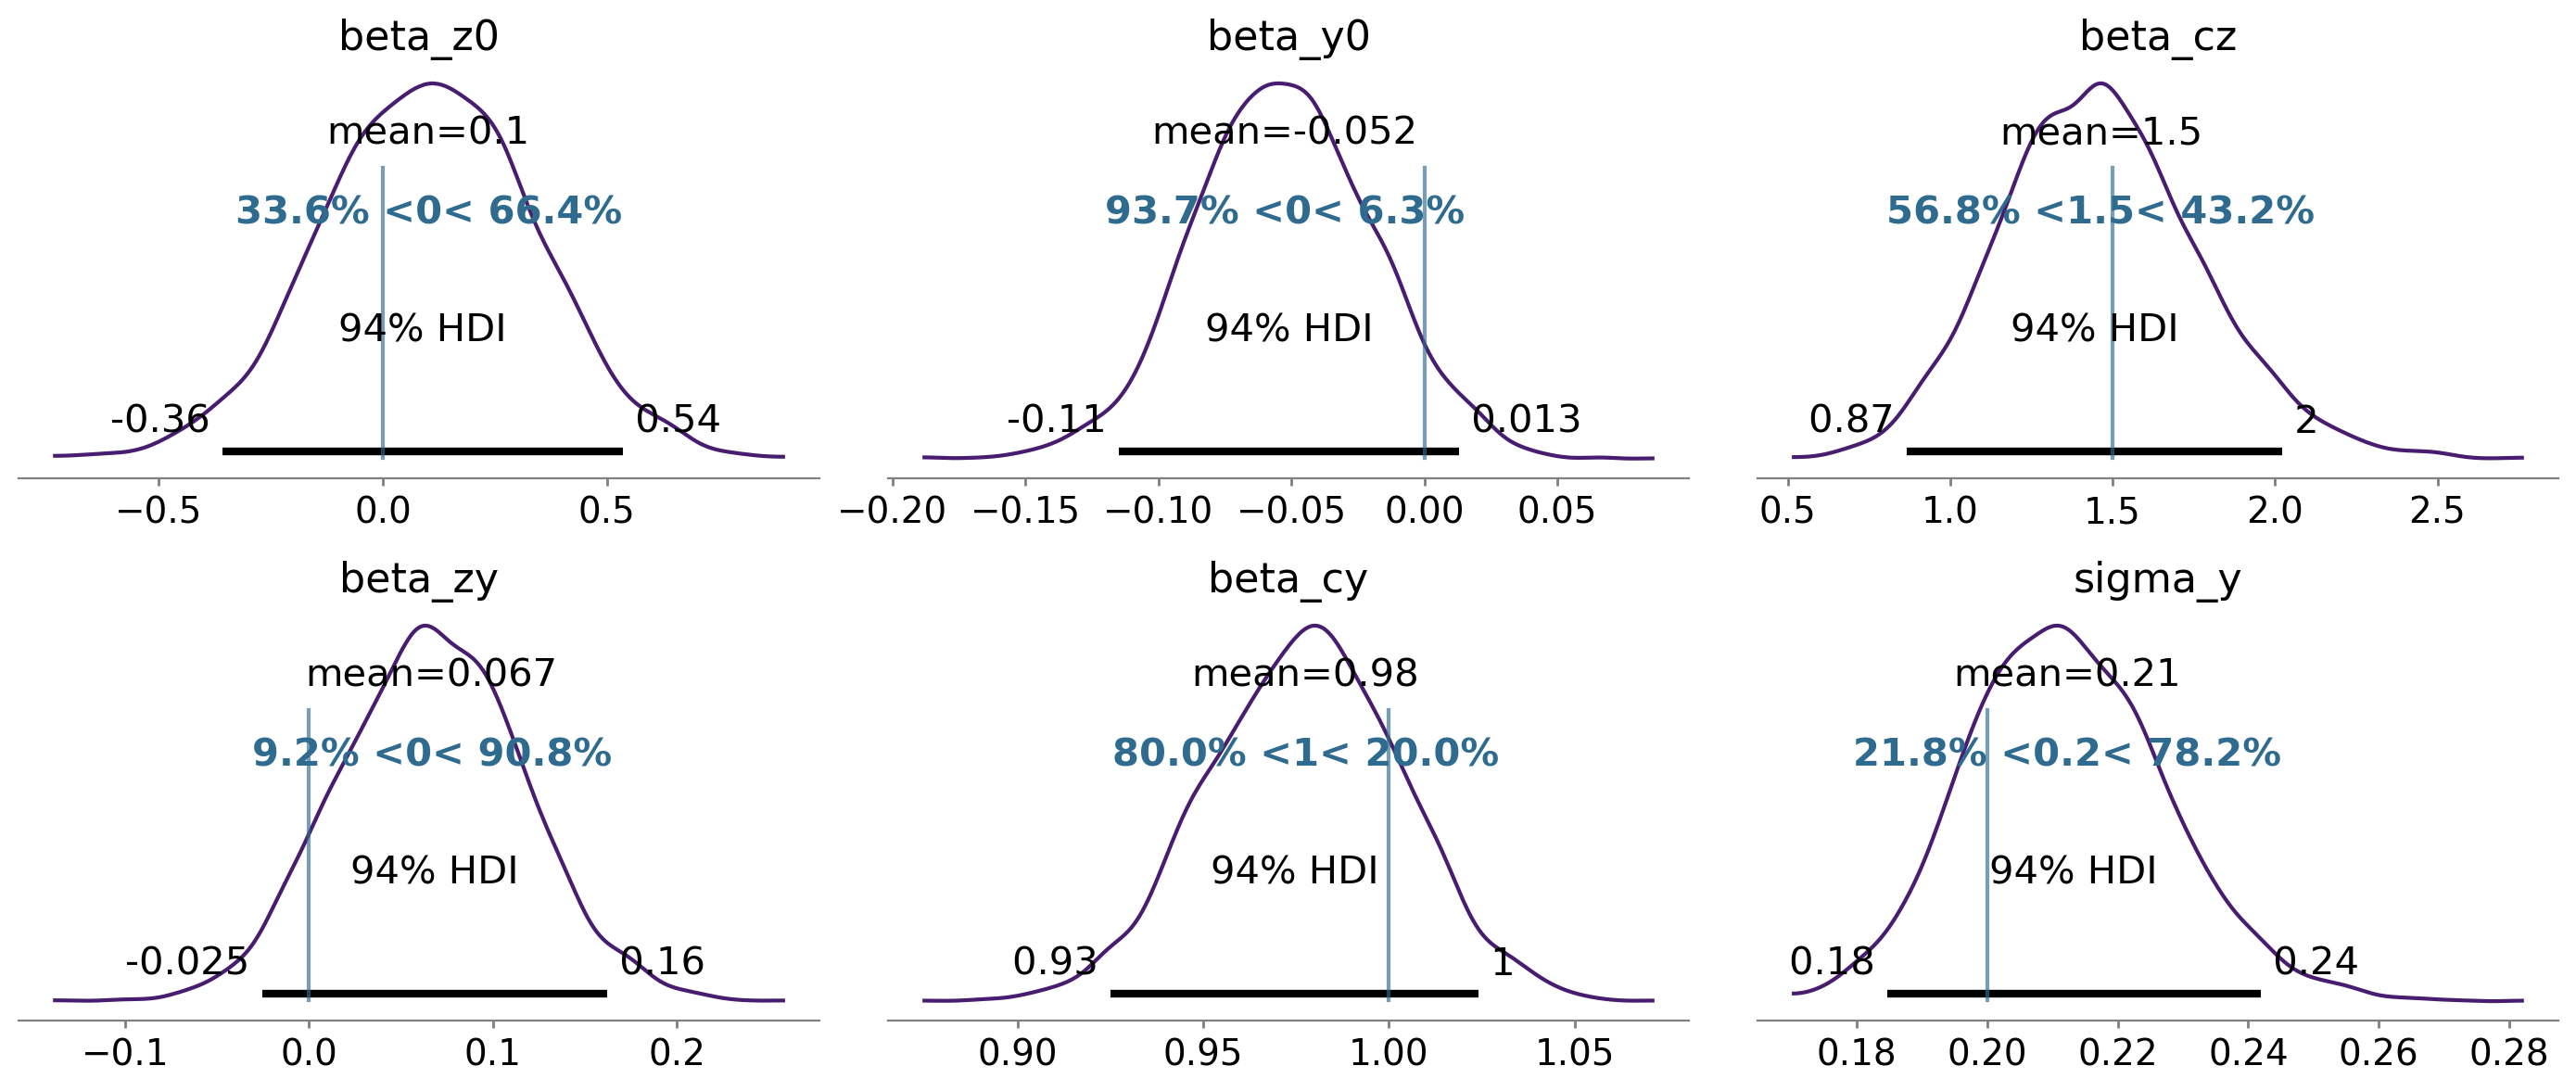

In [51]:
az.plot_posterior(
    idata,
    var_names=list(true_values.keys()),
    ref_val=list(true_values.values()),
    figsize=(14, 6),
)
plt.tight_layout();

Si noti che il parametro `beta_zy` (il cui vero valore è 0) viene stimato correttamente: 0.01, 94% CI [-0.07, 0.1]. Fino a qui abbiamo solo dimostrato che, usando il modello causale corretto, è possibile stimare i parametri in maniera non distorta. 

# Analisi controfattuale

Ora siamo pronti per esplorare l'utilizzo dell'operatore "do" per realizzare un ragionamento controfattuale. Questo approccio ci permette di formulare quesiti del tipo "Cosa succederebbe se?": ad esempio, cosa succederebbe se interrompessimo il trattamento TCC? 

È fondamentale sottolineare che, in questo scenario, viene eliminata qualsiasi influenza del fattore confondente (mindfulness), perché l'ipotesi di base è che possiamo attivare o disattivare l'influenza del trattamento TCC indipendentemente da quanto accade in relazione alla mindfulness. Questa è la logica che sottende l'utilizzo dell'operatore "do".

Una volta definito questo scenario controfattuale, il nostro obiettivo principale sarà quello di stimare l'entità dell'influenza causale del trattamento TCC sulla qualità della vita, isolando l'effetto del confondente rappresentato dalla mindfulness. 

Per chi è già familiare con l'inferenza causale, questo concetto è noto come "Effetto Medio del Trattamento" (Average Treatment Effect).

Per attuare questo processo in PyMC, possiamo utilizzare nuovamente la funzione `do()` per generare lo scenario controfattuale spiegato in precedenza. Prima di procedere con un comando come il seguente

$$
\text{{model\_z0 = do(model\_inference, \{"z": np.zeros(N, dtype="int32")\})}}
$$

dobbiamo sostituire la variabile casuale relativa alla mindfulness, indicata con "c", con i dati osservati presenti nella colonna "C" del nostro dataframe, in modo da evitare che venga rieseguito il campionamento in seguito.

In [52]:
# Replace c with its observed values
model_counterfactual = pm.do(model_inference, {"c": df["c"]})

Ora siamo in grado di utilizzare l'operatore `do()` per impostare tutti i valori di $ Z $ a 0 o a 1, al fine di calcolare $ Y_{\text{do}(Z=0)} $ e $ Y_{\text{do}(Z=1)} $, rispettivamente.

In [53]:
# Generate models with Z=0 and Z=1
model_z0 = pm.do(model_counterfactual, {"z": np.zeros(N, dtype="int32")}, prune_vars=True)
model_z1 = pm.do(model_counterfactual, {"z": np.ones(N, dtype="int32")}, prune_vars=True)

Questo ci fornisce i nostri due modelli per gli scenari "cosa succederebbe se". Poiché siamo interessati a quali dati ci aspetteremmo di osservare in questi scenari ipotetici, il passo successivo è simulare nuovi dati per entrambi i modelli.

Questo si realizza attraverso l'affidabile funzione `pm.sample_posterior_predictive()`, che genera nuovi dati a partire da un modello e da un tracciato dell'inferenza a posteriori (ossia i dati `idata` ottenuti precedentemente quando abbiamo adattato il modello ai dati, includendo i valori a posteriori dei coefficienti di regressione che abbiamo stimato).

In [55]:
# Sample well-being data assuming mindfulness off: P(Y | c, do(z=0))
idata_z0 = pm.sample_posterior_predictive(
    idata,
    model=model_z0,
    predictions=True,
    var_names=["y_mu"],
    random_seed=rng,
)
# Sample well-being data assuming mindfulness on: P(Y | c, do(z=1))
idata_z1 = pm.sample_posterior_predictive(
    idata,
    model=model_z1,
    predictions=True,
    var_names=["y_mu"],
    random_seed=rng,
)

Sampling: []


Sampling: []


Data questa serie ipotetica di dati sulla qualità della vita, ottenuta dalle due simulazioni degli interventi, possiamo calcolare la differenza nella qualità della vita come conseguenza della presenza o assenza del trattamento TCC per ottenere la stima dell'Effetto Medio del Trattamento (Average Treatment Effect, ATE).

In [56]:
# calculate estimated ATE
ATE_est = idata_z1.predictions - idata_z0.predictions
print(f"Estimated ATE = {ATE_est.y_mu.mean().values:.2f}")

Estimated ATE = 0.07


In [57]:
def plot_causal_estimates(models, ATE_est, model_names):
    """Utility plot function to generate figure for estimated outcomes and causal effects."""
    fig, ax = plt.subplots(1, 2)

    # left plot of estimated outcomes
    ret = az.plot_forest(
        [models[0].predictions, models[1].predictions],
        combined=True,
        ax=ax[0],
        model_names=model_names,
    )
    # remove alternate row shading
    for p in ret[0].patches:
        p.set_color("white")

    # right plot of estimated ATE
    az.plot_posterior(
        idata, var_names="beta_zy", ref_val=true_ATE, round_to=4, ax=ax[1]
    )

    # formatting
    ax[0].set(
        title="Estimated outcomes under intervention",
        ylabel="unit, $i$ (ordered)",
        yticklabels=[],
    )
    ax[1].set(title="Average Treatment Effect")
    plt.tight_layout()

    plt.suptitle(
        "Unit level estimates with do operation,\nand estimate of Average Treatment Effect",
        y=1.05,
    );

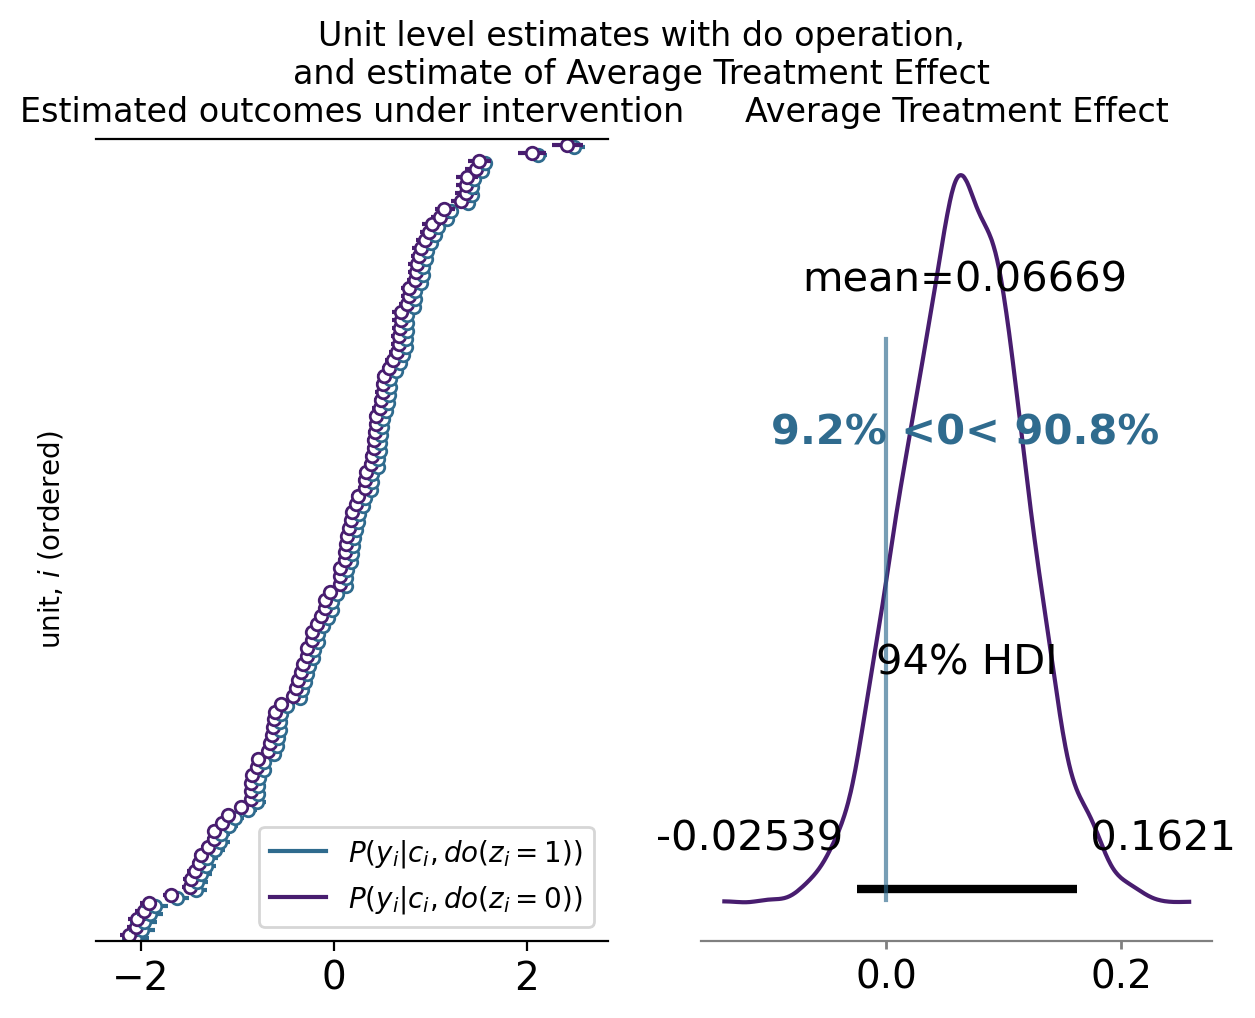

In [58]:
plot_causal_estimates(
    [idata_z0, idata_z1],
    ATE_est,
    model_names=[r"$P(y_i|c_i,do(z_i=0))$", r"$P(y_i|c_i,do(z_i=1))$"],
)

In [59]:
percent = (idata.posterior["beta_zy"] / idata.posterior["beta_cy"]) * 100
print(
    f"Causal effect of the TCC treatment on QoL is {percent.mean():.1f}% [{az.hdi(percent).x.data[0]:.1f}%,{az.hdi(percent).x.data[1]:.1f}%] of the effect of mindfulness on QoL"
)

Causal effect of the TCC treatment on QoL is 6.9% [-2.6%,17.1%] of the effect of mindfulness on QoL


## Commenti e considerazioni conclusive

Analizzando lo stesso insieme di dati attraverso due analisi statistiche diverse, basate su presupposti differenti riguardo il meccanismo generatore dei dati, arriviamo a conclusioni opposte. Nel primo caso, trascurando l'effetto di una variabile confondente, deduciamo che il trattamento con la Terapia Cognitivo-Comportamentale (TCC) è efficace nel migliorare la qualità della vita. Nel secondo, invece, tenendo conto dell'effetto potenziale della variabile confondente, concludiamo che il trattamento TCC non ha effetto sul miglioramento della qualità della vita, risultato che rispecchia la struttura causale che abbiamo usato per generare i dati.

Questo esempio evidenzia in maniera chiara quanto sia facile essere ingannati dalle correlazioni. Inizialmente sembrava che il trattamento TCC avesse un effetto positivo sulla qualità della vita, ma questa percezione era frutto dell'influenza della pratica della mindfulness. Tale illusione si dissolve quando analizziamo i dati in due scenari diversi: uno in cui manteniamo l'effetto della mindfulness e uno in cui lo eliminiamo. Se ci fossimo limitati a valutare l'associazione tra le variabili, avremmo erroneamente concluso che il trattamento TCC è efficace, una deduzione non supportata dalla realtà dei dati simulati. Inoltre, è fondamentale considerare l'incertezza che accompagna le stime puntuali. Nonostante abbiamo identificato un lieve effetto positivo del trattamento TCC, l'intervallo di credibilità ci mostra che la stima è troppo influenzata dal rumore per confermare con certezza un effetto positivo.

Questo caso studio mette in luce l'importanza e l'efficacia dell'approccio bayesiano nella modellazione causale, un approccio che può essere facilmente implementato con PyMC. Definendo accuratamente il processo generativo dei dati e sfruttando strumenti come l'operatore "do()", possiamo simulare interventi tenendo conto sia delle relazioni causali che dell'incertezza associata ai parametri del modello. Ciò ci permette di condurre analisi di tipo "cosa succederebbe se" in scenari ipotetici, fornendo una visione più completa e sofisticata delle dinamiche causali presenti nei nostri dati.

## Watermark

In [60]:
%load_ext watermark
%watermark -n -u -v -iv 

The watermark extension is already loaded. To reload it, use:
  %reload_ext watermark
Last updated: Tue Sep 19 2023

Python implementation: CPython
Python version       : 3.11.5
IPython version      : 8.15.0

matplotlib: 3.7.1
pymc      : 5.8.1
networkx  : 3.1
seaborn   : 0.12.2
bambi     : 0.12.0
pandas    : 1.5.3
arviz     : 0.15.1
numpy     : 1.23.5

